In [1]:
# import libraries
# try:
#   # %tensorflow_version only exists in Colab.
#   !pip install tf-nightly
# except Exception:
#   pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# !pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2023-08-06 02:52:20.389166: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-06 02:52:20.423511: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 02:52:20.647314: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9346] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-08-06 02:52:20.647443: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-08-06 02:52:20.647808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
2.15.0-dev20230805


In [2]:
from os.path import exists

if not exists("./train-data.tsv"):
    # get data files
    !wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
    !wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

In [3]:
train_data = pd.read_table(train_file_path, header=None, names=["spam", "message"])
train_data.head()

,spam,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [4]:
train_data.isnull().sum()

spam       0
message    0
dtype: int64

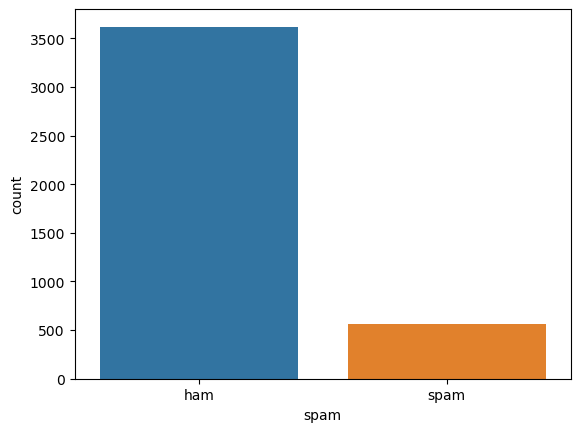

In [5]:
"""
for a better understanding, plot these counts

* the number of ham is much more than that of spam!
* the dataset is imbalanced...
"""
import seaborn as sns

sns.countplot(x='spam', data=train_data)
plt.show()

In [6]:
test_data = pd.read_table(test_file_path, header=None, names=["spam", "message"])
test_data.head()

,spam,message
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [7]:
test_data.isnull().sum()

spam       0
message    0
dtype: int64

In [8]:
train_data["spam"] = train_data["spam"].replace({"ham": 0, "spam": 1})
test_data["spam"] = test_data["spam"].replace({"ham": 0, "spam": 1})
train_data["spam"].value_counts()

spam
0    3619
1     560
Name: count, dtype: int64

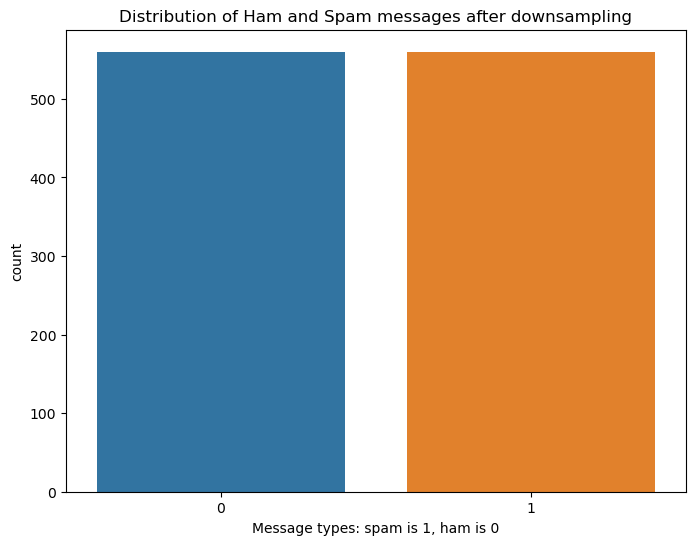

In [9]:
"""
Downsampling to ensure that data bias does not negatively affect learning
"""
# Downsampling to balance the dataset
ham_msg = train_data[train_data["spam"] == 0]
spam_msg = train_data[train_data.spam == 1]
ham_msg = ham_msg.sample(
    n=len(spam_msg),
    random_state=42
)

# Plotting the counts of down sampled dataset
balanced_data = pd.concat([ham_msg, spam_msg])

plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam messages after downsampling')
plt.xlabel('Message types: spam is 1, ham is 0')
plt.show()

In [10]:
"""
delete puctuations from texts
"""
import string
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['message'] = balanced_data['message'].apply(lambda x: remove_punctuations(x))

# Perform the same pre-processing on test data as on training data.
test_data['message'] = test_data['message'].apply(lambda x: remove_punctuations(x))

balanced_data.head()

,spam,message
2549,0,hi im having the most relaxing time ever we ha...
2313,0,see you there
2643,0,ill be at yours in about 3 mins but look out f...
3386,0,i will vote for wherever my heart guides me
3465,0,babe i lost you


In [11]:
"""
delete stopwords from data
"""
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output

balanced_data['message'] = balanced_data['message'].apply(lambda text: remove_stopwords(text))

# Perform the same pre-processing on test data as on training data.
test_data['message'] = test_data['message'].apply(lambda text: remove_stopwords(text))

balanced_data.head()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,spam,message
2549,0,hi im relaxing time ever get 7am every day par...
2313,0,see
2643,0,ill 3 mins look
3386,0,vote wherever heart guides
3465,0,babe lost


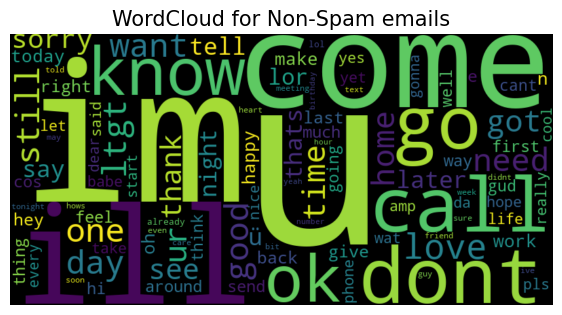

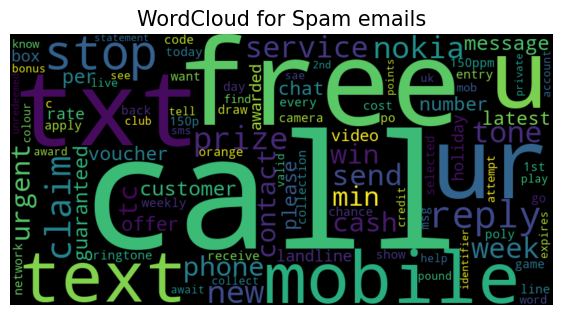

In [12]:
"""
visualize data by wordcloud

The results show that there are differences in the constituent words between spam and ham.
"""
from wordcloud import WordCloud
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['message'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(
        background_color='black',
        max_words=100,
        width=800,
        height=400,
        collocations=False
    ).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

In [13]:
"""
split label from data
"""
train_labels = balanced_data.pop("spam")
test_labels = test_data.pop("spam")

balanced_data

,message
2549,hi im relaxing time ever get 7am every day par...
2313,see
2643,ill 3 mins look
3386,vote wherever heart guides
3465,babe lost
...,...
4164,free msg single find partner area 1000s real p...
4165,free2day sexy st georges day pic jordantxt pic...
4167,winner specially selected receive £1000 cash £...
4176,free entry £250 weekly competition text word w...


In [14]:
"""
convert dataframe to ndarray
"""
train_X = balanced_data["message"].to_numpy()
train_Y = train_labels.to_numpy()
test_X = test_data["message"].to_numpy()
test_Y = test_labels.to_numpy()
train_X

array(['hi im relaxing time ever get 7am every day party good night get home tomorrow 5ish',
       'see', 'ill 3 mins look', ...,
       'winner specially selected receive £1000 cash £2000 award speak live operator claim call 087147123779am7pm cost 10p',
       'free entry £250 weekly competition text word win 80086 18 tc wwwtxttowincouk',
       'pls stop bootydelious 32f inviting friend reply yes434 no434 see wwwsmsacubootydelious stop send stop frnd 62468'],
      dtype=object)

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
# maximum sequence length
max_len = 100
train_sequences = pad_sequences(
    train_sequences,
    maxlen=max_len,
    padding='post',
    truncating='post'
)
test_sequences = pad_sequences(
    test_sequences,
    maxlen=max_len,
    padding='post',
    truncating='post'
)
print(train_sequences)

[[  60   14 1713 ...    0    0    0]
 [  36    0    0 ...    0    0    0]
 [  32   80   55 ...    0    0    0]
 ...
 [ 177  295  105 ...    0    0    0]
 [   3   95  199 ...    0    0    0]
 [ 113   11 4048 ...    0    0    0]]


In [23]:
"""
model development
"""
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=32,
    input_length=max_len
))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           129696    
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 133409 (521.13 KB)
Trainable params: 133409 (521.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
"""
model compile
"""
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = ['accuracy'],
    optimizer = 'adam'
)

In [25]:
"""
train the model
"""
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# callback
es = EarlyStopping(
    patience=3,
    monitor = 'val_accuracy',
    restore_best_weights = True
)
 
lr = ReduceLROnPlateau(
    patience = 2,
    monitor = 'val_loss',
    factor = 0.5,
    verbose = 0
)

# Train the model
history = model.fit(
    train_sequences, 
    train_labels,
    validation_data=(test_sequences, test_labels),
    epochs=20,
    batch_size=32,
    callbacks = [lr, es]
)

Epoch 1/20


/opt/conda/lib/python3.11/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


35/35 [==============================] - 3s 46ms/step - loss: 0.6936 - accuracy: 0.4946 - val_loss: 0.6920 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 2/20
35/35 [==============================] - 1s 31ms/step - loss: 0.6934 - accuracy: 0.4804 - val_loss: 0.6903 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 3/20
35/35 [==============================] - 1s 32ms/step - loss: 0.6933 - accuracy: 0.4821 - val_loss: 0.6889 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 4/20
35/35 [==============================] - 1s 34ms/step - loss: 0.6933 - accuracy: 0.4750 - val_loss: 0.6929 - val_accuracy: 0.8657 - lr: 0.0010


In [34]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
intTolabel = {0: "ham", 1: "spam"}

def predict_message(pred_text):
  pred_text = remove_punctuations(pred_text)
  pred_text = remove_stopwords(pred_text)

  sequence = tokenizer.texts_to_sequences([pred_text])
  sequence = pad_sequences(sequence, maxlen=max_len)

  prediction = model.predict(sequence)[0]
  label = intTolabel[np.argmax(prediction)]

  return (prediction[0], label)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 23ms/step
[0.4979103]
(0.4979103, 'ham')


In [35]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 19ms/step
[0.4979103]
1/1 [==============================] - 0s 21ms/step
[0.49731287]
1/1 [==============================] - 0s 19ms/step
[0.49490273]
1/1 [==============================] - 0s 19ms/step
[0.4945565]
1/1 [==============================] - 0s 21ms/step
[0.49699524]
1/1 [==============================] - 0s 22ms/step
[0.4949325]
1/1 [==============================] - 0s 22ms/step
[0.4956571]
You haven't passed yet. Keep trying.
